In [1]:
import numpy as np
import matplotlib.pyplot as plt

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import backprop
from backprop import gp

SAMPLE_SIZE = 200
NOISE = 0.03

POPSIZE = 1000
MAX_STREE_DEPTH = 8
GENERATIONS = 200
GROUP_SIZE = 5  # tournament selector.
MUTATION_RATE = 0.05
ELITISM = 1

NBESTS = 4

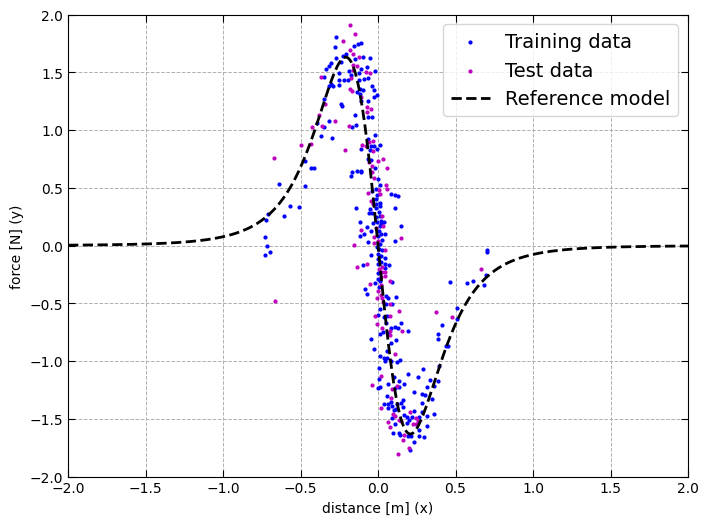

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()
#S.sample(size=250, noise=0.0, mesh=False)
S.load('../data/magman.csv')
S.split()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [ ]:
population = gp.random_population(popsize=POPSIZE, max_depth=MAX_STREE_DEPTH, nvars=S.nvars)
multiMutator = gp.MultiMutator(
      gp.SubtreeReplacerMutator(MAX_STREE_DEPTH),
      gp.FunctionSymbolMutator(),
      gp.NumericParameterMutator(all=True),
      gp.NumericParameterMutator(all=False)
      )

symb_regressor = \
         gp.GP(population, GENERATIONS, S_train, S_test,
               evaluator=gp.R2Evaluator(S_train),
               selector=gp.TournamentSelector(GROUP_SIZE),
               crossover=gp.SubTreeCrossover(),
               mutator=multiMutator,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               nbests=NBESTS)

with np.errstate(all='ignore'):
      bests, eval_map = symb_regressor.evolve()
best_stree = bests[0]
best_eval = eval_map[id(best_stree)]

print("--- Best syntax tree ---")
print(best_stree)
print(best_eval)

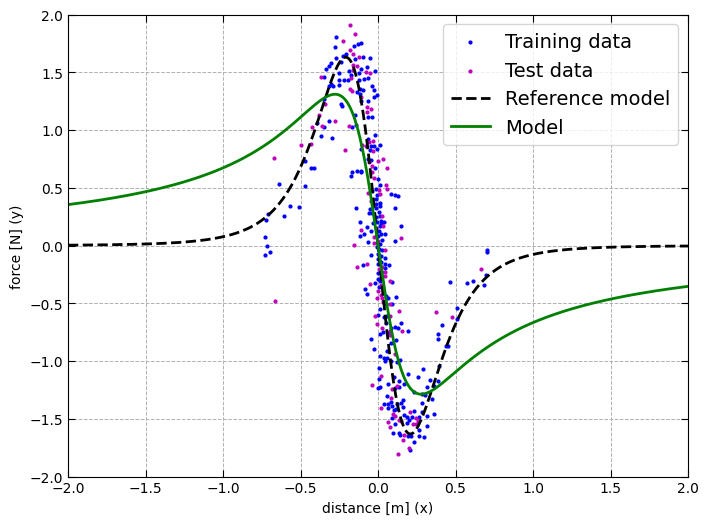

In [4]:
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree)

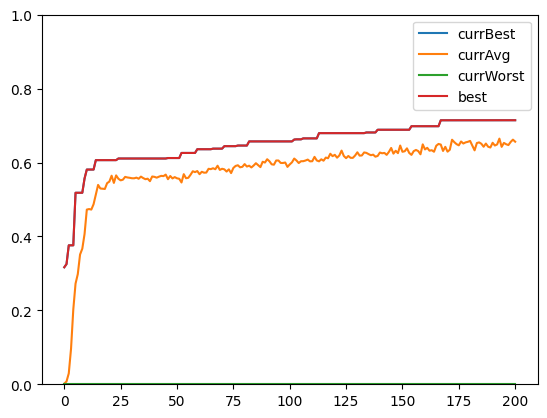

In [6]:
plt.ylim((0.,1.))
for quality, qseries in symb_regressor.qualities.items():
    plt.plot(qseries, label=quality)
plt.legend()